# Test-Time Adaptation

In [1]:
import torch
import torchvision.transforms as T
import torchvision.models as models
import torchvision
from test_methods.test import Tester
from test_time_adaptation.resnet50_dropout import ResNet50Dropout

In [3]:
imagenet_a_path = "imagenet-a"
imagenet_b_path = "imagenetv2-matched-frequency-format-val/"

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
import torchvision.transforms as T

augmentations = [
    T.RandomHorizontalFlip(p=1),
    T.RandomVerticalFlip(p=1),
    T.RandomRotation(degrees=30),
    T.RandomRotation(degrees=60),
    T.ColorJitter(brightness=0.2),
    T.ColorJitter(contrast=0.2),
    T.ColorJitter(saturation=0.2),
    T.ColorJitter(hue=0.2),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.RandomRotation(degrees=15),
    T.RandomAdjustSharpness(sharpness_factor=2, p=1),
    T.RandomGrayscale(p=1),
    T.RandomInvert(p=1),
    T.RandomAutocontrast(p=1),
    T.GaussianBlur(kernel_size=5),
]

augmix_augmentations = [
    T.AugMix(severity=3, mixture_width=3, chain_depth=3, alpha=1.0),
    T.AugMix(severity=2, mixture_width=2, chain_depth=3, alpha=1.0),
    T.AugMix(severity=4, mixture_width=4, chain_depth=3, alpha=1.0),
    T.AugMix(severity=3, mixture_width=3, chain_depth=3, alpha=1.0),
    T.AugMix(severity=2, mixture_width=2, chain_depth=3, alpha=1.0),
    T.AugMix(severity=4, mixture_width=4, chain_depth=3, alpha=1.0),
    T.AugMix(severity=3, mixture_width=3, chain_depth=3, alpha=1.0),
    T.AugMix(severity=2, mixture_width=2, chain_depth=3, alpha=1.0),
    T.AugMix(severity=4, mixture_width=4, chain_depth=3, alpha=1.0),
    T.AugMix(severity=3, mixture_width=3, chain_depth=3, alpha=1.0),
    T.AugMix(severity=2, mixture_width=2, chain_depth=3, alpha=1.0),
    T.AugMix(severity=4, mixture_width=4, chain_depth=3, alpha=1.0),
    T.AugMix(severity=3, mixture_width=3, chain_depth=3, alpha=1.0),
    T.AugMix(severity=2, mixture_width=2, chain_depth=3, alpha=1.0),
    T.AugMix(severity=4, mixture_width=4, chain_depth=3, alpha=1.0),
    T.AugMix(severity=3, mixture_width=3, chain_depth=3, alpha=1.0),
    T.AugMix(severity=2, mixture_width=2, chain_depth=3, alpha=1.0),
    T.AugMix(severity=4, mixture_width=4, chain_depth=3, alpha=1.0)
]

## Resnet50

In [6]:
exp_path_a = "/home/sagemaker-user/Domain-Shift-Computer-Vision/experiments/Resnet50_ImagenetA_SGD"

In [1]:
MC = {
	"dropout_rate": 0.5,
	"num_samples": 10,
	"use_dropout": True
}

In [7]:
tester_resnet50 = Tester(
    model = ResNet50Dropout() if MC['use_dropout'] else models.resnet50,
    optimizer = torch.optim.SGD,
    exp_path = exp_path_a,
    device = device
)

In [8]:
#lr_setting = [{
#    "classifier" : [["fc.weight", "fc.bias"], 0.00025]    
#}, 0]
lr_setting_sgd = [0.00025] # setting used in MEMO paper for SGD
lr_setting_adam = [0.0001] # setting used in MEMO paper for ADAM

In [9]:
imagenetV1_weights = models.ResNet50_Weights.IMAGENET1K_V1 # MEMO paper used these weights
imagenetV2_weights = models.ResNet50_Weights.IMAGENET1K_V2

In [ ]:
tester_resnet50.test(
     augmentations = augmix_augmentations, 
     num_augmentations = 16,
     seed_augmentations = 42,
     batch_size = 64, 
     img_root = imagenet_a_path,
     MEMO = False,
     lr_setting = None,
     top_augmentations = 8,
     weights_imagenet = imagenetV1_weights,
     prior_strength = 0.,
     TTA = True,
     MC = MC
)

-----

In [ ]:
!pip install ollama

In [ ]:
!pip install diffusers

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

In [2]:
import torch

In [2]:
from test_time_adaptation.image_generation.image_generator import ImageGenerator

In [3]:
imagenetA_generator = ImageGenerator()

In [ ]:
# generate prompts
skipped_classes = imagenetA_generator.generate_prompts(
    num_prompts=2,
    style_of_picture="photograph",
    path="/home/sagemaker-user/Domain-Shift-Computer-Vision/imagenetA_generated",
    context_llm = "/home/sagemaker-user/Domain-Shift-Computer-Vision/test_time_adaptation/image_generation/llm_context.json"
)

In [ ]:
# generate images
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler

model_id = "runwayml/stable-diffusion-v1-5"
pipet2i = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipet2i.scheduler = DPMSolverMultistepScheduler.from_config(pipet2i.scheduler.config)
pipet2i = pipet2i.to("cuda")

In [50]:
imagenet_a_generated_path = "/home/sagemaker-user/Domain-Shift-Computer-Vision/imagenetA_generated"

In [ ]:
imagenetA_generator.generate_images(path = imagenet_a_generated_path,
                                    num_images = 1,
                                    image_generation_pipeline = pipet2i,
                                    num_inference_steps = 25,
                                    guidance_scale = 9,
                                    strength=1)

------

In [43]:
from utility.data.get_data import get_data
import clip
import torch
import torch.nn.functional as F
from PIL import Image

In [44]:
dataloader = get_data(batch_size=32, 
                      img_root = "imagenet-a",
                      split_data=False)

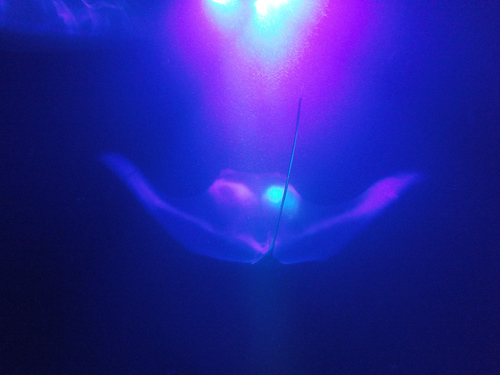

In [322]:
dataloader.dataset[20][0]

In [323]:
candle_img = dataloader.dataset[20][0]

In [46]:
clip_image_encoder = "ViT-L/14"
clip_model, preprocess = clip.load(clip_image_encoder)

In [51]:
imagenet_a_generated_path = "/home/sagemaker-user/Domain-Shift-Computer-Vision/imagenetA_generated"

In [381]:
retrieved_images = retrieve_gen_images(img = candle_img,
                                       num_images = 30,
                                       data_path = imagenet_a_generated_path,
                                       clip_model = clip_model,
                                       preprocess = preprocess,
                                       t2i_images = True,
                                       use_t2i_similarity = False,
                                       threshold = 0.7
                                        )

In [380]:
def retrieve_gen_images(img, data_path, num_images, clip_model, preprocess, use_t2i_similarity = False, 
                        t2i_images = True, i2i_images = False, threshold = 0):

    assert i2i_images or t2i_images, "One of t2i_images and i2i_images must be true"

    retrieved_images_paths = []
    retrieved_images_similarity = torch.zeros(num_images)
    with torch.no_grad():
        image_embedding = clip_model.encode_image(preprocess(img).unsqueeze(0).cuda())
        image_embedding /= image_embedding.norm()
    
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        for gen_images_class in os.listdir(class_path):
            gen_images_class_path = os.path.join(class_path,gen_images_class)
            gen_prompt_embedding = torch.load(os.path.join(gen_images_class_path, "prompt_clip_embedding.pt"))
            t2i_similarity = F.cosine_similarity(image_embedding, gen_prompt_embedding)
            if t2i_images:
                t2i_gen_images_main_path = os.path.join(gen_images_class_path,"t2i_gen_images")
                try: # needed bc some prompts don't have a corresponding image yet
                    for t2i_images_paths in os.listdir(t2i_gen_images_main_path):
                        t2i_image_path = os.path.join(t2i_gen_images_main_path,t2i_images_paths)
                        gen_image_embedding = torch.load(os.path.join(t2i_image_path, "image_embedding.pt"))
                        i2i_similarity = F.cosine_similarity(image_embedding, gen_image_embedding)
                        if use_t2i_similarity:
                            similarity = (i2i_similarity + t2i_similarity)/2 # avg similarity
                        else:
                            similarity = i2i_similarity
                        if similarity < threshold: continue
                        if len(retrieved_images_paths) < num_images:
                            retrieved_images_similarity[len(retrieved_images_paths)] = similarity
                            retrieved_images_paths.append(os.path.join(t2i_image_path, "image.png"))
                        else:
                            min_similarity, id_similarity = retrieved_images_similarity.min(dim=0)
                            if similarity > min_similarity:
                                retrieved_images_similarity[id_similarity] = similarity
                                retrieved_images_paths[id_similarity] = os.path.join(t2i_image_path, "image.png")
                except:
                    pass
            if i2i_images:
                i2i_gen_images_main_path = os.path.join(gen_images_class_path,"i2i_gen_images")
                for i2i_images_paths in os.listdir(i2i_gen_images_main_path):
                    i2i_image_path = os.path.join(i2i_gen_images_main_path,i2i_images_paths)
                    gen_image_embedding = torch.load(os.path.join(i2i_image_path, "image_embedding.pt"))
    
                    i2i_similarity = F.cosine_similarity(image_embedding, gen_image_embedding)
                    if use_t2i_similarity:
                        similarity = (i2i_similarity + t2i_similarity)/2 # avg similarity
                    else:
                        similarity = i2i_similarity
                    if similarity < threshold: continue
                    if len(retrieved_images) < num_images:
                        retrieved_images_similarity[len(retrieved_images_paths)] = similarity
                        retrieved_images_paths.append(os.path.join(t2i_image_path, "image.png"))
                    else:
                        min_similarity, id_similarity = retrieved_images_similarity.min(dim=0)
                        if similarity > min_similarity:
                            retrieved_images_similarity[id_similarity] = similarity
                            retrieved_images_paths[id_similarity] = os.path.join(i2i_image_path, "image.png")

    retrieved_images = []
    for image_path in retrieved_images_paths:
        retrieved_images.append(torchvision.transforms.ToTensor()(Image.open(image_path)))

    retrieved_images = torch.stack(retrieved_images)
    
    return retrieved_images